# Solve Problem 1: Helmholtz Equation without potential with PINN


### Equation:
$$
i \partial_t u(x,t) = - \Delta u(x,t) + V(x,t) u(x,t), \quad x \in \Omega, \ t > 0, \\
\quad \partial_t u(x,0) = u_0(x), \quad x \in \Omega, \\
\quad u(x,t) = g(x,t), \quad x \in \Gamma_D, t>0, \\
\quad \partial_n u(x,t) = h(x,t), \quad x \in \Gamma_N, t> 0.
$$
where the potential $V(x,t)$ is zero, i.e., $V(x,t) = 0$.

## Formulate the PINN loss function:
Starting with the classical PINN approach, we define the residual function of the PDE as:
$$
R(x,t) = i \partial_t u(x,t) - \Delta u(x,t) - V(x,t) u(x,t), \quad x \in \Omega, \ t > 0.
$$
The goal is to minimize this residual, for that we add into the loss the residual loss, initial condition loss, and boundary condition loss:
$$
\mathcal{L}(\theta) = \mathcal{L}_{\text{PDE}}(\theta) + \mathcal{L}_{\text{IC}}(\theta) + \mathcal{L}_{\text{BC}}(\theta),
$$
where
$$
\mathcal{L}_{\text{PDE}}(\theta) = \frac{1}{N_{\text{PDE}}} \sum_{i=1}^{N_{\text{PDE}}} R(x_i, t_i; \theta)^2,
$$
$$
\mathcal{L}_{\text{IC}}(\theta) = \frac{1}{N_{\text{IC}}} \sum_{i=1}^{N_{\text{IC}}} (u(x_i, 0; \theta) - u_0(x_i))^2,
$$
$$
\mathcal{L}_{\text{BC}}(\theta) = \frac{1}{N_{\text{BC}}} \sum_{i=1}^{N_{\text{BC}}} (u(x_i, t_i; \theta) - g(x_i, t_i))^2 + \frac{1}{N_{\text{BC}}} \sum_{i=1}^{N_{\text{BC}}} (\partial_n u(x_i, t_i; \theta) - h(x_i, t_i))^2.
$$



## Initial and Boundary Conditions:
The initial condition is given by:
$$
u(x,0) = \sin(\pi x_1)\sin(\pi x_2), \quad x \in \Omega,
$$
where $\Omega = [0,1]^2$.
The boundary conditions are homogeneous Dirichlet boundary conditions:
$$
u(x,t) = 0, \quad \forall x \in \partial \Omega,\; t > 0.
$$

## Layout of the PINN:
The handling of complex numbers in the PINN is done by separating the real and imaginary parts of the solution, meaning the output of the PINN has to be a vector of the form:
$$
u(x,t) = \begin{pmatrix}
\text{Re}(u(x,t)) \\
\text{Im}(u(x,t))
\end{pmatrix}.
$$

The Input are then sampling points in the domain $\Omega$ and time $t$, i.e., the input are then triples of the form $(x_1, x_2, t)$, where $x_1, x_2 \in [0,1]$ and $t > 0$.



## Define the PINN:

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


In [40]:
class PINN(nn.Module):
    def __init__(self, *args, **kwargs):
        """ 
        PINN model for solving PDEs.
        """
        super().__init__(*args, **kwargs)
        self.linear1 = nn.Linear (3,32)
        self.linear2 = nn.Linear(32, 64)
        self.linear3 = nn.Linear(64, 64)
        self.linear4 = nn.Linear(64,2)
        self.activation = nn.Tanh()

    def forward(self, x):
        """ Forward pass through the network.
        Input:
            x: input tensor of shape (N, 3)
        Output:
            output: tensor of shape (N, 2) (Real and Imaginary parts of the solution)
        """
        x = self.activation(self.linear1(x))
        x = self.activation(self.linear2(x))
        x = self.activation(self.linear3(x))
        output = self.linear4(x)
        return output

### Define Derivatives:

In [41]:

def get_gradients(model, x):
    """
    Compute gradients of the model output with respect to the input.
    Input:
        model: PINN model
        x: input tensor of shape (N, 3)
    Output:
        gradients: tensor of shape (N, 2, 3) containing gradients
        with respect to Re(u) and Im(u) for each input dimension (x1, x2, t)
    """
    output = model(x)  # shape (N, 2)
    grads = []
    for i in range(output.shape[1]):  # for Re(u), Im(u)
        grad = torch.autograd.grad(
            outputs=output[:, i],
            inputs=x,
            grad_outputs=torch.ones_like(output[:, i]),
            create_graph=True,
            retain_graph=True
        )[0]  # shape (N, 3)
        grads.append(grad)
    gradients = torch.stack(grads, dim=1)  # shape (N, 2, 3)
    return gradients

def second_derivative(y,x,idx):
    """ 
    Compute the second derivatives
    needs special handling because the model has real and imaginary parts which needs to be handled separately
    Input:
        y: output tensor of shape (N, 2) (Real and Imaginary parts)
        x: input tensor of shape (N, 3)
        idx: index for which second derivative is computed (0 for x1, 1 for x2, 2 for t)
    """
    grad = torch.autograd.grad(
        outputs = y,
        inputs = x,
        grad_outputs=torch.ones_like(y),
        create_graph=True,
        retain_graph=True
    )[0][:, idx]  # shape (N, 3)
    return grad


### Define Loss Functions

In [ ]:

def loss_physics(model, x):
    """
    Residual loss coming from the PDE
    Input:
        model: PINN model
        x: input tensor of shape (N, 3)
    Output:
        loss: scalar tensor
    """
    u = model(x)

    # first derivatives
    grads = get_gradients(model, x)  # shape (N, 2, 3)
    dx1 = grads[:, :, 0]  # shape (N, 2) because of Real and Imaginary parts
    dx2 = grads[:, :, 1]  # shape (N, 2)
    dt = grads[:, :, 2]  # shape (N, 2)


    # get the second derivatives for the laplacian, real and imaginary parts
    u_r_x1 = dx1[:, 0]  # Real part gradient w.r.t x1
    u_r_x2 = dx2[:, 0]  # Real part gradient w.r
    u_r_x1x1 = second_derivative(u_r_x1, x, 0)
    u_r_x2x2 = second_derivative(u_r_x2, x, 1)
    lap_u_r = u_r_x1x1 + u_r_x2x2  # Laplacian of the real part

    u_i_x1 = dx1[:, 1]  # Imaginary part gradient w.r.t x1
    u_i_x2 = dx2[:, 1]  # Imaginary part gradient w.r
    u_i_x1x1 = second_derivative(u_i_x1, x, 0)
    u_i_x2x2 = second_derivative(u_i_x2, x, 1)
    lap_u_i = u_i_x1x1 + u_i_x2x2  # Laplacian of the imaginary part

    # time derivatives in real and imaginary parts
    u_r_t = dt[:, 0]  # Real part time derivative
    u_i_t = dt[:, 1]  # Imaginary part time derivative


    # Residuals for the PDE in real and imaginary parts
    res_real = -u_i_t + lap_u_r  # Residual for the real part
    res_imag = u_r_t + lap_u_i  # Residual for the imaginary part

    # Compute the loss as the mean squared error, |z|^2 = Re(z)^2 + Im(z)^2
    loss = torch.mean(res_real**2 + res_imag**2)  # Mean squared error of the residuals
    return loss
    

def loss_boundary(model, x_b):
    """
    Boundary loss for the PINN.
    Input:
        model: PINN model
        x_b: input tensor of boundary points and t>0, shape (N, 3)
    Output:
        loss: scalar tensor
    """
    u_b = model(x_b)  # shape (N, 2)
    
    # Boundary condition: u(x1, x2, t) = 0 on the boundary
    loss = torch.mean(u_b[:, 0]**2 + u_b[:, 1]**2)  # Mean squared error of the boundary condition
    return loss

def loss_initial(model, x_i):
    """ 
    Initial condition loss for the PINN.
    u(x1, x2, 0) = sin(pi*x1) * sin(pi*x2)
    Input:
        model: PINN model
        x_i: input tensor of initial points at t=0, shape (N, 3)
    Output:
        loss: scalar tensor
    """
    u_i = model(x_i)  # shape (N, 2)
    
    initial_r = torch.sin(np.pi * x_i[:, 0]) * torch.sin(np.pi * x_i[:, 1])  # Real part of initial condition
    initial_i = torch.zeros_like(initial_r)  # Imaginary part of initial condition is zero

    # residuals
    res_r = u_i[:, 0] - initial_r  # Residual for the real part
    res_i = u_i[:, 1] - initial_i  # Residual for the imaginary part

    # print("real loss:", torch.mean(res_r**2).item(), "imaginary loss:", torch.mean(res_i**2).item())
    # compute the loss as the mean squared error
    loss = torch.mean(res_r**2 + res_i**2)  # Mean squared error of the initial condition

    return loss

def total_loss(model, x_b, x_i, x_pde):
    """
    Total loss function combining boundary, initial, and PDE losses.
    Input:
        model: PINN model
        x_b: boundary points
        x_i: initial points
        x_pde: PDE points
    Output:
        total_loss: scalar tensor
    """

    lambda_bc = 1.0  # Weight for boundary loss
    lambda_ic = 1.0  # Weight for initial condition loss
    lambda_pde = 1.0  # Weight for PDE loss
    
    loss_bc = loss_boundary(model, x_b)  # Boundary loss
    loss_ic = loss_initial(model, x_i)  # Initial condition loss
    loss_pde = loss_physics(model, x_pde)  # PDE loss

    total_loss = lambda_bc * loss_bc + lambda_ic * loss_ic + lambda_pde * loss_pde  # Combine losses
    return total_loss

### Train the model:

Functions for sampling points

In [43]:
# sample points for the boundary and initial conditions
T = 0.1


def sample_boundary_points(num_points, T=0.1):
    """
    Sample points on the boundary of the domain [0,1]^2.
    Output: tensor of shape (num_points, 3)
    """
    x1 = np.zeros(num_points)
    x2 = np.zeros(num_points)
    t = np.random.uniform(0.01, T, num_points)

    # Divide points equally among the four edges
    num_per_edge = num_points // 4

    # x1 = 0, x2 in [0,1]
    x1[:num_per_edge] = 0.0
    x2[:num_per_edge] = np.random.uniform(0, 1, num_per_edge)

    # x1 = 1, x2 in [0,1]
    x1[num_per_edge:2*num_per_edge] = 1.0
    x2[num_per_edge:2*num_per_edge] = np.random.uniform(0, 1, num_per_edge)

    # x2 = 0, x1 in [0,1]
    x1[2*num_per_edge:3*num_per_edge] = np.random.uniform(0, 1, num_per_edge)
    x2[2*num_per_edge:3*num_per_edge] = 0.0

    # x2 = 1, x1 in [0,1]
    x1[3*num_per_edge:] = np.random.uniform(0, 1, num_points - 3*num_per_edge)
    x2[3*num_per_edge:] = 1.0

    x_b = np.column_stack((x1, x2, t))
    return torch.tensor(x_b, dtype=torch.float32, requires_grad=True)


def sample_initial_points(num_points):
    """
    Sample points at the initial time t=0.
    Input:
        num_points: number of points to sample
    Output:
        x_i: tensor of shape (num_points, 3) containing sampled points
    """
    x1 = np.random.uniform(0, 1, num_points)
    x2 = np.random.uniform(0, 1, num_points)
    t = np.zeros(num_points)  # t = 0
    x_i = np.column_stack((x1, x2, t))
    return torch.tensor(x_i, dtype=torch.float32, requires_grad=True)

def sample_interior_points(num_points, T = 0.1):
    """
    Sample points in the interior of the domain.
    Input:
        num_points: number of points to sample
    Output:
        x_i: tensor of shape (num_points, 3) containing sampled points
    """
    x1 = np.random.uniform(0, 1, num_points)
    x2 = np.random.uniform(0, 1, num_points)
    t = np.random.uniform(0, T, num_points)  # t in [0, T]
    x_i = np.column_stack((x1, x2, t))
    return torch.tensor(x_i, dtype=torch.float32, requires_grad=True)



Training the model

Epoch 0, Loss: 0.33113160729408264
Epoch 100, Loss: 0.1627044379711151
Epoch 200, Loss: 0.147350013256073
Epoch 300, Loss: 0.11206536740064621
Epoch 400, Loss: 0.0901765301823616
Epoch 500, Loss: 0.08104578405618668
Epoch 600, Loss: 0.07864038646221161
Epoch 700, Loss: 0.07592985779047012
Epoch 800, Loss: 0.07546232640743256
Epoch 900, Loss: 0.07514676451683044
Epoch 1000, Loss: 0.07479334622621536
Epoch 1100, Loss: 0.07448465377092361
Epoch 1200, Loss: 0.0741148591041565
Epoch 1300, Loss: 0.07376142591238022
Epoch 1400, Loss: 0.07339438796043396
Epoch 1500, Loss: 0.07302559912204742
Epoch 1600, Loss: 0.07255212217569351
Epoch 1700, Loss: 0.07298305630683899
Epoch 1800, Loss: 0.07170547544956207
Epoch 1900, Loss: 0.0711311399936676
Epoch 2000, Loss: 0.07075471431016922
Epoch 2100, Loss: 0.07045511156320572
Epoch 2200, Loss: 0.07399541139602661
Epoch 2300, Loss: 0.06976111233234406
Epoch 2400, Loss: 0.06946496665477753
Epoch 2500, Loss: 0.06920408457517624
Epoch 2600, Loss: 0.0688643380

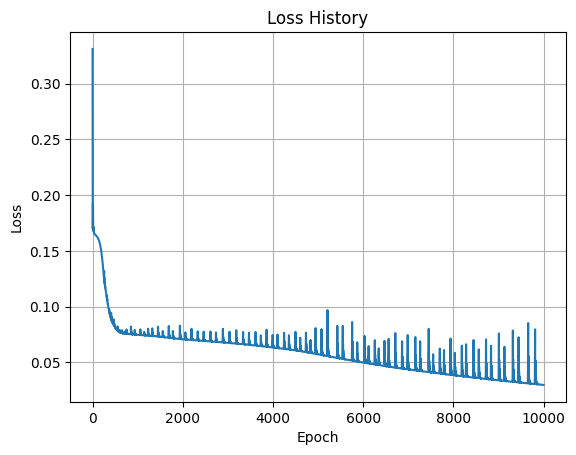

In [44]:

model = PINN()

N_points = 10000  # Number of points for boundary, initial, and PDE sampling
x_b = sample_boundary_points(N_points, T)  # Sample boundary points
x_i = sample_initial_points(N_points)  # Sample initial points
x_pde = sample_interior_points(N_points, T)  # Sample PDE points


optimizer = optim.Adam(
    params=model.parameters(),
    lr=0.001,
    betas=(0.9, 0.999),
    eps=1e-08,
    weight_decay=0,
    amsgrad=False
)

epochs = 10000
loss_history = []


for epoch in range(epochs):
    optimizer.zero_grad()
    loss = total_loss(model, x_b, x_i, x_pde)  # Compute total loss
    loss.backward()  # Backpropagation
    optimizer.step()  # Update model parameters
    loss_history.append(loss.item())  # Store loss for plotting
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")  # Print loss every 100 epochs

# print all different losses
print(f"Boundary Loss: {loss_boundary(model, x_b).item()}")
print(f"Initial Condition Loss: {loss_initial(model, x_i).item()}")
print(f"PDE Loss: {loss_physics(model, x_pde).item()}")


# Plot the loss history
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss History')
plt.grid()
plt.show()


In [48]:
# print all different losses
print(f"Boundary Loss: {loss_boundary(model, x_b).item()}")
print(f"Initial Condition Loss: {loss_initial(model, x_i).item()}")
print(f"PDE Loss: {loss_physics(model, x_pde).item()}")


Boundary Loss: 0.013711050152778625
real loss: 0.01003488339483738 imaginary loss: 0.0021358083467930555
Initial Condition Loss: 0.012170691974461079
PDE Loss: 0.003943736664950848


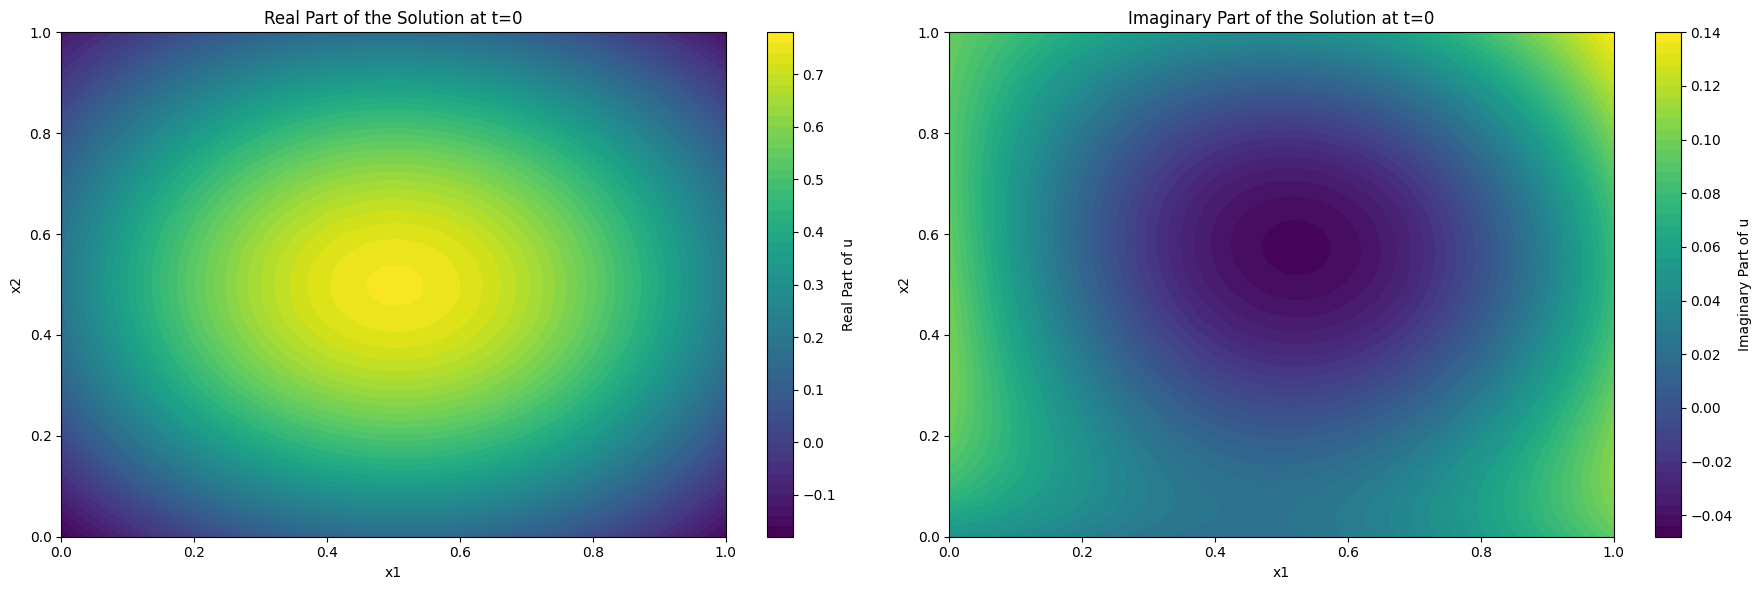

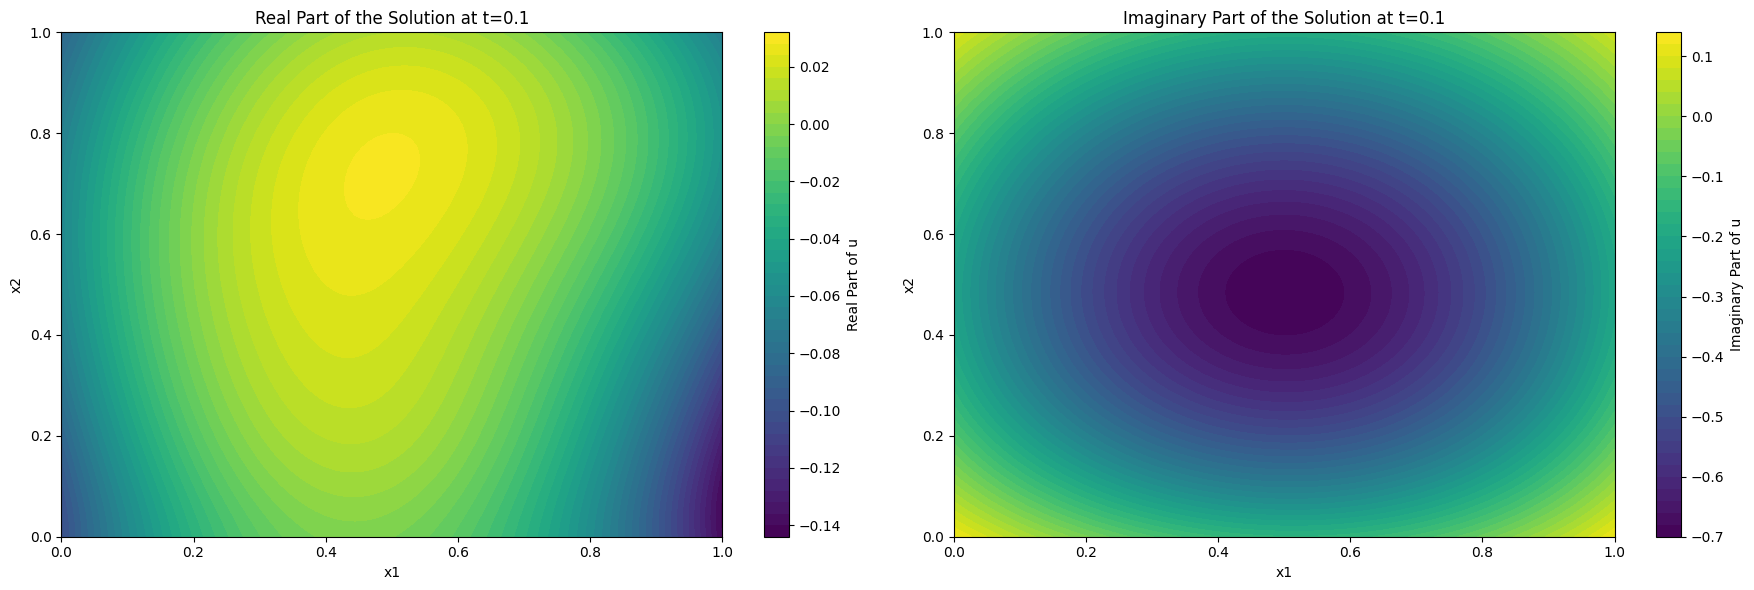

In [46]:
# plot the solution

def plot_model_output(model, t = 0):
    """
    Plot the model output for a given time t.
    Input:
        model: PINN model
        t: time at which to evaluate the model
    """
    x1 = np.linspace(0, 1, 100)
    x2 = np.linspace(0, 1, 100)
    X1, X2 = np.meshgrid(x1, x2)
    X = np.column_stack((X1.ravel(), X2.ravel(), np.full(X1.size, t)))  # t is constant for this plot
    X_tensor = torch.tensor(X, dtype=torch.float32, requires_grad=True)
    u_pred = model(X_tensor).detach().numpy()  # Get predictions from the model

    # Plot the real and imaginary parts of the solution as subplots
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # Real part
    cf1 = axes[0].contourf(X1, X2, u_pred[:, 0].reshape(X1.shape), levels=50, cmap='viridis')
    fig.colorbar(cf1, ax=axes[0], label='Real Part of u')
    axes[0].set_title(f'Real Part of the Solution at t={t}')
    axes[0].set_xlabel('x1')
    axes[0].set_ylabel('x2')

    # Imaginary part
    cf2 = axes[1].contourf(X1, X2, u_pred[:, 1].reshape(X1.shape), levels=50, cmap='viridis')
    fig.colorbar(cf2, ax=axes[1], label='Imaginary Part of u')
    axes[1].set_title(f'Imaginary Part of the Solution at t={t}')
    axes[1].set_xlabel('x1')
    axes[1].set_ylabel('x2')

    plt.tight_layout()
    plt.show()

plot_model_output(model, t=0)  # Plot at t=0
plot_model_output(model, t=0.1)  # Plot at t=0.1
